# Pràctica Cas Kaggle 
## CS:GO Competitive Matchmaking Data

### 0. Contexte
#### Què és CS:GO?

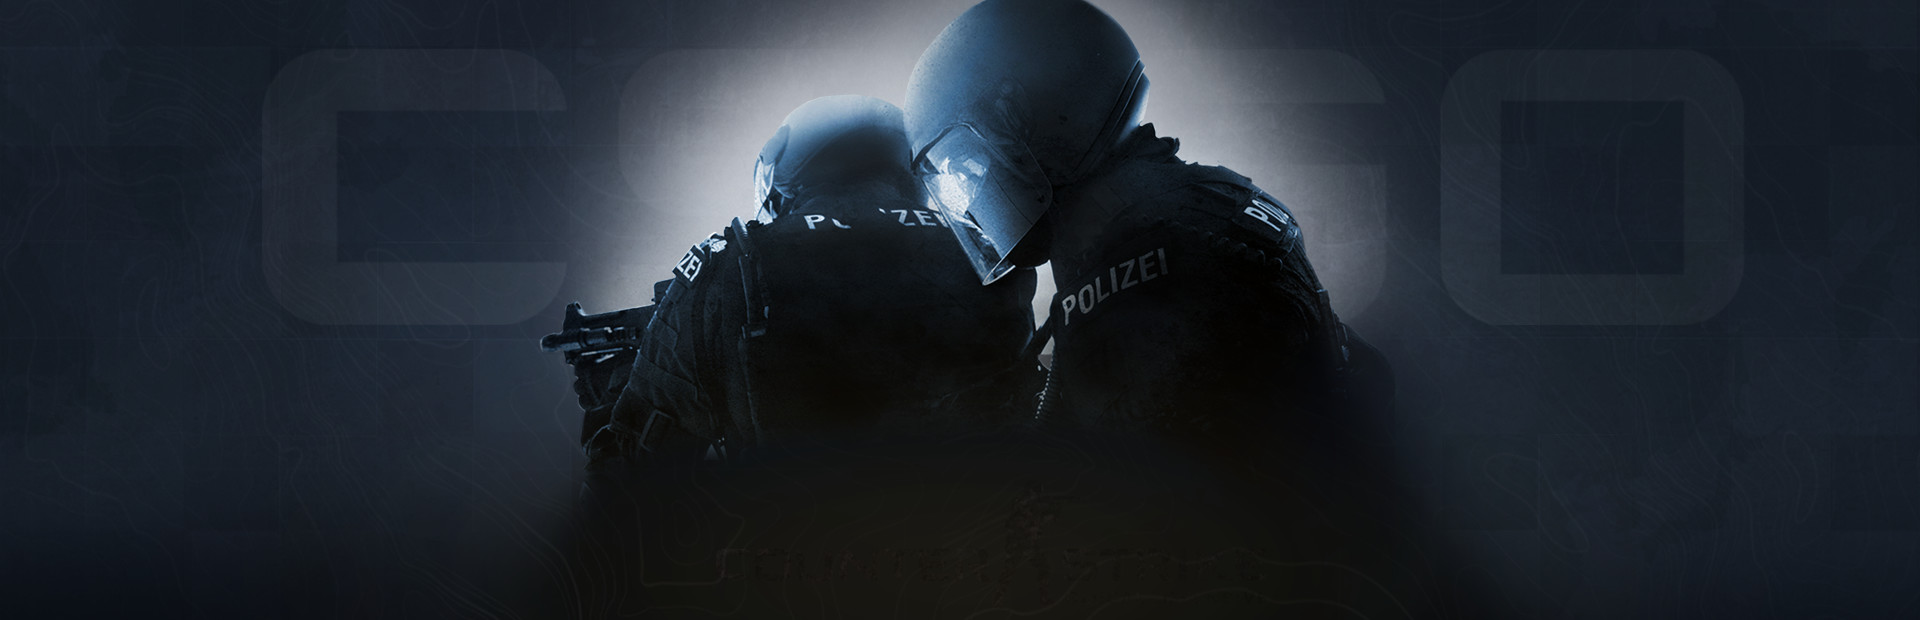

Counter Strike: Global Offensive és un videojoc multijugador gratuit per a ordinadors desenvolupat per Valve Corporation. El mode de joc principal consisteix en que un equip (Terrorists) intenten plantar una bomba en uns punts del mapa (marcats A o B) mentres que l'altre equip (Counter-Terrorists) intenta evitar-lo, i en cas de que la bomba sigui plantada han de desactivar-la.

Altres regles del joc inclouen:
* En cada equip hi ha 5 jugadors.
* Les partides consisteixen de 30 rondes com a màxim.
* Una ronda s'acaba quan un dels equips asoleix l'objectiu o s'acaba el temps. Si s'acaba el temps, guanyen els Counter-Terrorists.
* A partir de la ronda 15, els equips es canvien i es continua jugant fins que un dels equips aconsegueixi 16 rondes guanyades.

#### Xifres
* És un dels videojocs mes jugats i amb millors ingresos econòmics de la plataforma Steam
* Te un pic de al voltant de **1 millió de jugadors simultanis cada dia** [1]
* S'estima el nombre de jugadors totals entre **270 milions i 677.22 milions**[1]. No es un nombre exacte ja que Steam no revela el nombre de jugadors.
* A Twitch, la plataforma d'streaming de partides de videojocs més importants, va tindre un pic de **1,9 milions d'espectadors simultanis** al novembre de 2021. Moltes vegades está en el top 10 de videojocs mes vists[3]
* // esports....
* // dineros...

[1] Source: https://steamdb.info/app/730/graphs/

[2] Source: https://twitchtracker.com/games/32399

[3] Source: https://www.twitch.tv/directory?sort=VIEWER_COUNT

#### La base de dades

Conté informació de...

### 1. Lectura del dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score

C:\Users\user\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Funcions per a llegir dades en format csv
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset

# La majoria de les dades estan separades en multiples fitxers. Funcio util per a llegir totes les parts
def load_split_dataset(path, parts):
    dataset = pd.concat([pd.read_csv(path + ".part%d.csv" % x, header=0, delimiter=',') for x in range(1,parts+1)])
    return dataset

#### Dades dels mapes

In [3]:
# Carreguem dades dels mapes
map_data = load_dataset('dataset/map_data.csv')
map_data

,Unnamed: 0,EndX,EndY,ResX,ResY,StartX,StartY
0,de_cache,3752,3187,1024,1024,-2031,-2240
1,de_cbble,2282,3032,1024,1024,-3819,-3073
2,de_dust2,2127,3455,1024,1024,-2486,-1150
3,de_inferno,2797,3800,1024,1024,-1960,-1062
4,de_mirage,1912,1682,1024,1024,-3217,-3401
5,de_overpass,503,1740,1024,1024,-4820,-3591
6,de_train,2262,2447,1024,1024,-2436,-2469


Conté informació dels mapes del joc. Nom i cordenades Start i End. "Res" indica la resolució del fitxer PNG que ve inclos amb el dataset per a cada mapa.

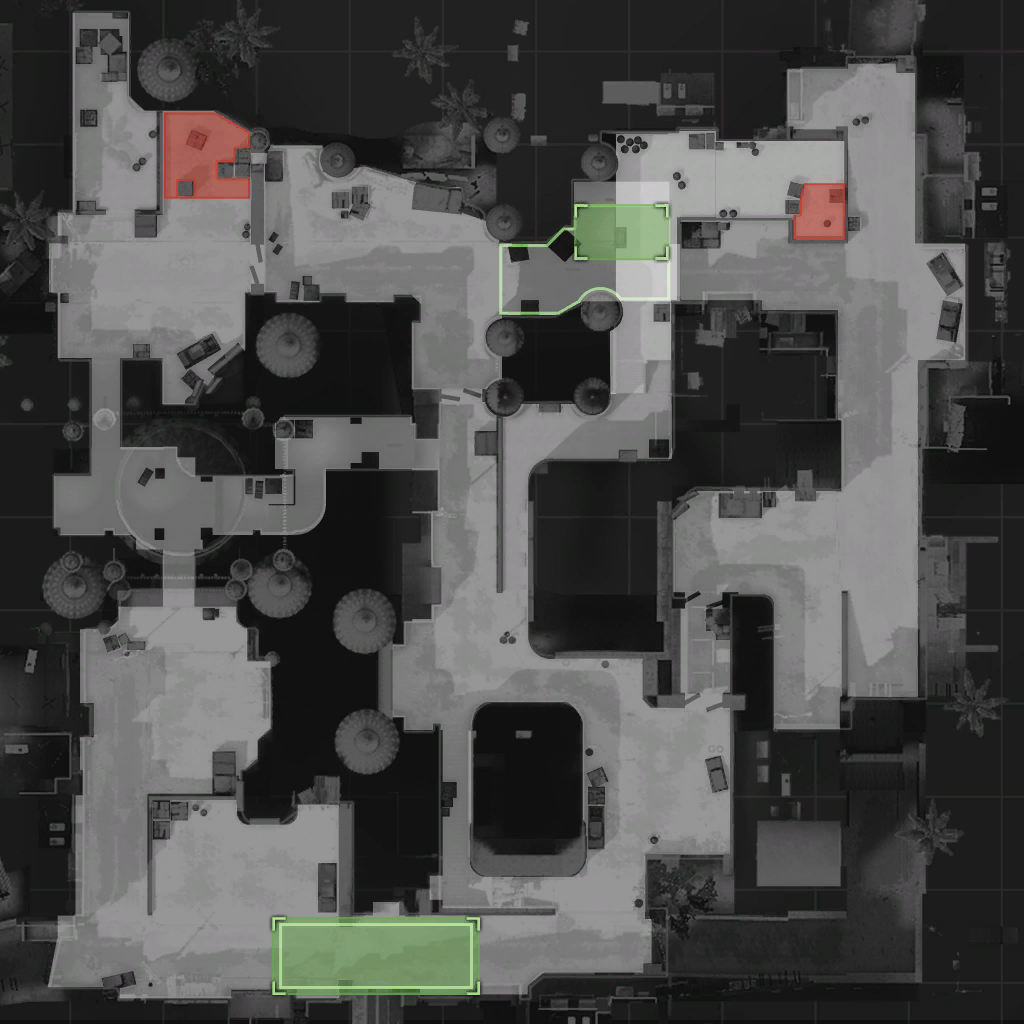
Exemple del mapa "de_dust2"

#### Dades de partides: servidors professionals ESEA https://play.esea.net/

In [4]:
# Carreguem dades de "meta"
meta_data = load_split_dataset('dataset/esea_meta_demos', 2)
meta_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 377629 entries, 0 to 161709
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   file           377629 non-null  object 
 1   map            377629 non-null  object 
 2   round          377629 non-null  int64  
 3   start_seconds  377589 non-null  float64
 4   end_seconds    377589 non-null  float64
 5   winner_team    377628 non-null  object 
 6   winner_side    377629 non-null  object 
 7   round_type     377629 non-null  object 
 8   ct_eq_val      377629 non-null  int64  
 9   t_eq_val       377629 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 31.7+ MB


Conté informació general de les partides. Explicació atributs:

**file**: Arxiu "dem" que emmagatzema la repetició de la partida. Identificador

**map**: nom del mapa utilitzat per a jugar la partida.

**round**: Numero de ronda

**start_seconds, end_seconds**: marca de temps en la qual comença / acaba la ronda.

**winner_team, winner_side**: equip i banda que ha guanyat la ronda.

**round_type**: tipus de ronda. Ex: NORMAL, PISTOL_ROUND, FORCE_BUY...

**ct_eq_val, t_eq_val**: Valor que ha invertit cada banda en equipament.


In [5]:
# Carreguem dades de "damage"
dmg_data = load_split_dataset('dataset/esea_master_dmg_demos', 2)
dmg_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10538182 entries, 0 to 4546084
Data columns (total 23 columns):
 #   Column           Dtype  
---  ------           -----  
 0   file             object 
 1   round            int64  
 2   tick             int64  
 3   seconds          float64
 4   att_team         object 
 5   vic_team         object 
 6   att_side         object 
 7   vic_side         object 
 8   hp_dmg           int64  
 9   arm_dmg          int64  
 10  is_bomb_planted  bool   
 11  bomb_site        object 
 12  hitbox           object 
 13  wp               object 
 14  wp_type          object 
 15  att_id           int64  
 16  att_rank         int64  
 17  vic_id           int64  
 18  vic_rank         int64  
 19  att_pos_x        float64
 20  att_pos_y        float64
 21  vic_pos_x        float64
 22  vic_pos_y        float64
dtypes: bool(1), float64(5), int64(8), object(9)
memory usage: 1.8+ GB


Explicació atributs:



tick, seconds: Indica el temps. Els ticks son els moments en que s'actualitza el mon del joc, típicament son 64 o 128 ticks per segon. Ofereixen mes precisió pero no els utilitzarem.

att_team, att_side: Equip i banda del jugador que ataca

vic_team, vic_side: Equip i banda de la víctima

hp_dmg:

arm_dmg:

is_bomb_planted: Indica si els terroristes han plantat la bomba.

bomb_site: En cas de que han plantat la bomba, en quin punt es troba? (A o B)

hitbox: On ha encertat la bala al disparar. Exemple: Head, Stomach, Chest... o Generic

wp: Nom de l'arma que ha disparat. Ex: Glock, USP...

wp_type: Tipus de l'arma que ha disparat. Ex: Pistol, Rifle...

att_id, att_rank, vic_id, vic_rank: ID i rang dels dos jugadors. Sembla que hi ha molts missing values i no influeix en la partida. Es pot descartar?

att_pos_x, att_pos_y; vic_pos_x, vic_pos_y: Posicions en el mapa dels dos jugadors.

In [6]:
# Drop atributs que no ens interessen
dmg_data = dmg_data.drop(columns=['tick','att_id','att_rank','vic_id','vic_rank'])

In [7]:
# Carreguem dades de "grenades"
grenades_data = load_split_dataset('dataset/esea_master_grenades_demos', 2)
grenades_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5246458 entries, 0 to 2256397
Data columns (total 23 columns):
 #   Column           Dtype  
---  ------           -----  
 0   file             object 
 1   round            int64  
 2   seconds          float64
 3   att_team         object 
 4   vic_team         object 
 5   att_id           int64  
 6   vic_id           float64
 7   att_side         object 
 8   vic_side         object 
 9   hp_dmg           int64  
 10  arm_dmg          int64  
 11  is_bomb_planted  bool   
 12  bomb_site        object 
 13  hitbox           object 
 14  nade             object 
 15  att_rank         int64  
 16  vic_rank         float64
 17  att_pos_x        float64
 18  att_pos_y        float64
 19  nade_land_x      float64
 20  nade_land_y      float64
 21  vic_pos_x        float64
 22  vic_pos_y        float64
dtypes: bool(1), float64(9), int64(5), object(8)
memory usage: 925.6+ MB


Explicació atributs:

nade:

nade_land_x, nade_land_y:

Utilitzarem aquestes dades?


In [8]:
# Drop atributs que no ens interessen
grenades_data = grenades_data.drop(columns=['att_id','att_rank','vic_id','vic_rank'])

In [9]:
# Carreguem dataset de kills
kills_data = load_split_dataset('dataset/esea_master_kills_demos', 2)
kills_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2742646 entries, 0 to 1173168
Data columns (total 13 columns):
 #   Column           Dtype  
---  ------           -----  
 0   file             object 
 1   round            int64  
 2   tick             int64  
 3   seconds          float64
 4   att_team         object 
 5   vic_team         object 
 6   att_side         object 
 7   vic_side         object 
 8   wp               object 
 9   wp_type          object 
 10  ct_alive         int64  
 11  t_alive          int64  
 12  is_bomb_planted  bool   
dtypes: bool(1), float64(1), int64(4), object(7)
memory usage: 274.6+ MB


Explicació dels atributs:

ct_alive, t_alive: quants jugadors queden vius en cada banda.

Aquestes dades semblen les mes útils per a fer models. Estan més resumides?

In [10]:
# Drop atributs que no ens interessen
kills_data = kills_data.drop(columns=['tick','att_team','vic_team'])

#### Dades de partides: Matchmaking servidors oficials

In [11]:
# Carregar dades de MM
mm_master_demos = load_dataset('dataset/mm_master_demos.csv')
mm_master_demos.info()

#mm_grenades_demos = load_dataset('dataset/mm_grenades_demos.csv')
#mm_grenades_demos.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955466 entries, 0 to 955465
Data columns (total 33 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       955466 non-null  int64  
 1   file             955466 non-null  object 
 2   map              955466 non-null  object 
 3   date             955466 non-null  object 
 4   round            955466 non-null  int64  
 5   tick             955466 non-null  int64  
 6   seconds          955466 non-null  float64
 7   att_team         955466 non-null  object 
 8   vic_team         955466 non-null  object 
 9   att_side         955466 non-null  object 
 10  vic_side         955466 non-null  object 
 11  hp_dmg           955466 non-null  int64  
 12  arm_dmg          955466 non-null  int64  
 13  is_bomb_planted  955466 non-null  bool   
 14  bomb_site        151039 non-null  object 
 15  hitbox           955466 non-null  object 
 16  wp               955466 non-null  obje

In [12]:
# Drop atributs que no ens interessen
mm_master_demos = mm_master_demos.drop(columns=['tick','date','award','att_id','att_rank','vic_id','vic_rank','avg_match_rank'])

### 2. Anàlisi de les dades

In [13]:
# TODO: preprocesament:
# eliminar outliers? mirar correlacions y todo

In [14]:
# Mostrar tots els equips
meta_data['winner_team'].value_counts()

Team 1                  192564
Team 2                  184262
Team Kinguin                74
Izako Boars                 57
PRiDE                       49
MVP PK                      48
ALTERNATE aTTaX             46
--to be determined--        41
SZ Absolute                 41
EURONICS Gaming             32
Ground Zero                 32
Sprout                      32
AGO Esports                 32
Chiefs                      32
Grayhound                   31
Endpoint                    31
PACT                        27
Dynasty                     25
BOOT-dS Letou               24
SYF                         22
FlashGaming                 19
Legacy                      16
Hentai Hooligans            15
Guerrilla Tactics           15
Taboo                       14
x-kom Team                  11
Animal Style                 9
ONCA Gaming                  8
fish123                      8
Cerus eSports                7
anime savants                4
Name: winner_team, dtype: int64

Hi ha un parell d'equips que son placeholders perque no s'ha registrat quin equip ha guanyat. Aixo fa que no sigui usable, eliminem.

In [15]:
# Eliminem columna
meta_data = meta_data.drop('winner_team', axis=1)
#dmg_data.drop('vic_team', axis=1)
#dmg_data.drop('att_team', axis=1)
#kills_data.drop('vic_team', axis=1)
#kills_data.drop('att_team', axis=1)

#grenades_data.drop('vic_team', axis=1)
#grenades_data.drop('att_team', axis=1)
mm_master_demos = mm_master_demos.drop(columns=['vic_team','att_team'])

<AxesSubplot:ylabel='winner_side'>

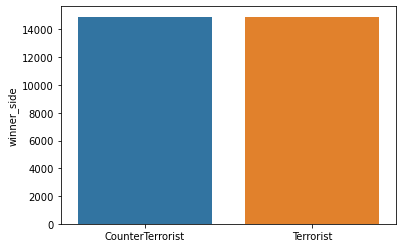

In [16]:
# Quin equip (side) guanya mes? (en ESEA)
side_counts = meta_data.groupby(['file','winner_side']).count().reset_index()['winner_side'].value_counts().head(2)
sns.barplot(x=side_counts.index, y=side_counts)

<AxesSubplot:ylabel='winner_side'>

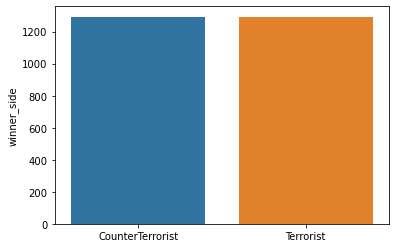

In [17]:
# Quin equip (side) guanya mes? (en matchmaking)
side_counts = mm_master_demos.groupby(['file','winner_side']).count().reset_index()['winner_side'].value_counts()
sns.barplot(x=side_counts.index, y=side_counts)

<AxesSubplot:ylabel='map'>

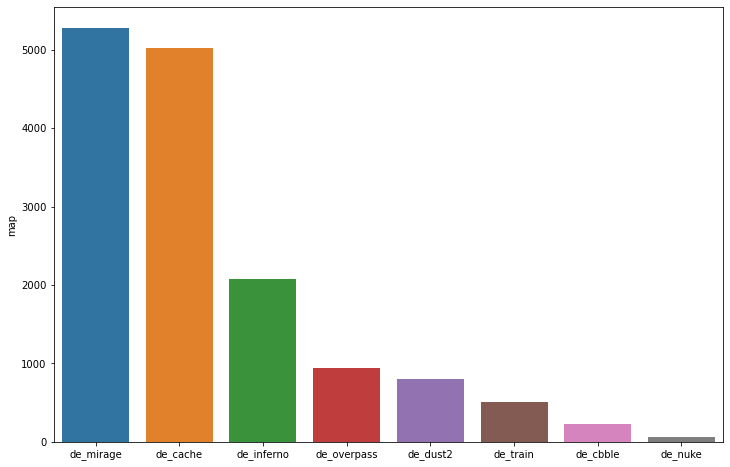

In [18]:
# Quins son els mapes mes populars? (ESEA)
side_counts = meta_data.groupby(['file','map']).count().reset_index()['map'].value_counts().head(10)
plt.subplots(figsize = (12,8))
sns.barplot(x=side_counts.index, y=side_counts)

<AxesSubplot:ylabel='map'>

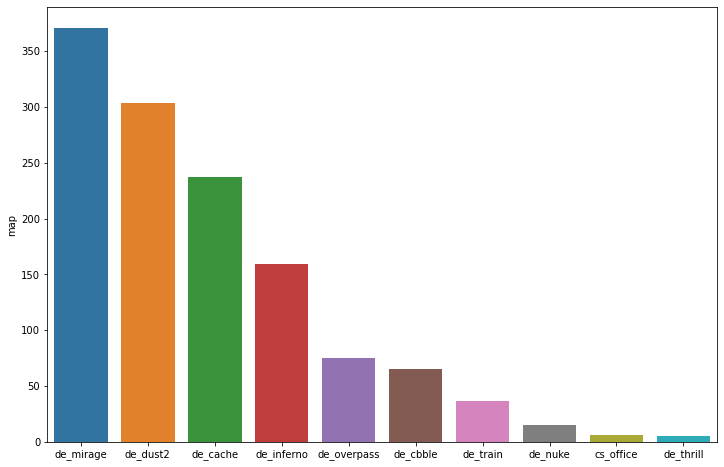

In [19]:
# Quins son els mapes mes populars? (matchmaking)
side_counts = mm_master_demos.groupby(['file','map']).count().reset_index()['map'].value_counts().head(10)
plt.subplots(figsize = (12,8))
sns.barplot(x=side_counts.index, y=side_counts)

array([[<AxesSubplot:title={'center':'round'}>,
        <AxesSubplot:title={'center':'start_seconds'}>],
       [<AxesSubplot:title={'center':'end_seconds'}>,
        <AxesSubplot:title={'center':'ct_eq_val'}>],
       [<AxesSubplot:title={'center':'t_eq_val'}>, <AxesSubplot:>]],
      dtype=object)

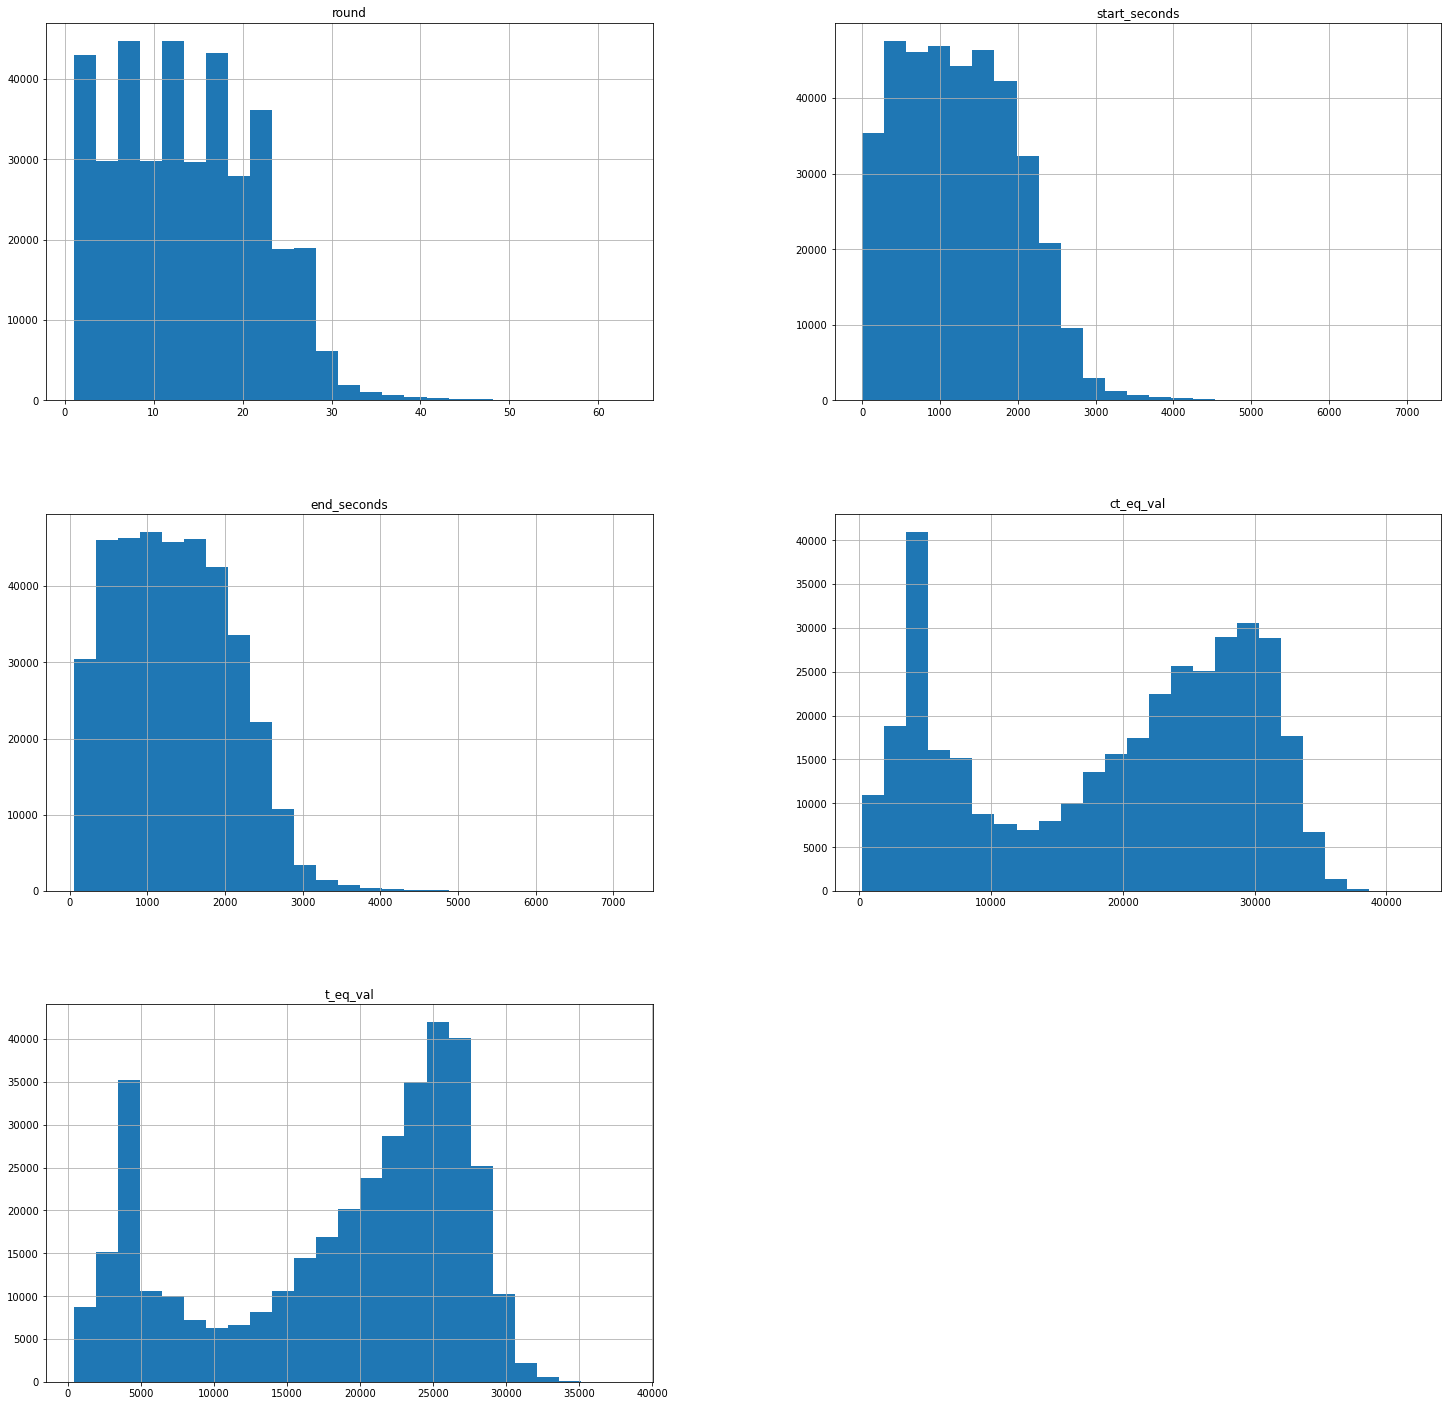

In [20]:
# Generar histogrames, general
meta_data.hist(bins=25, figsize=(25, 25))

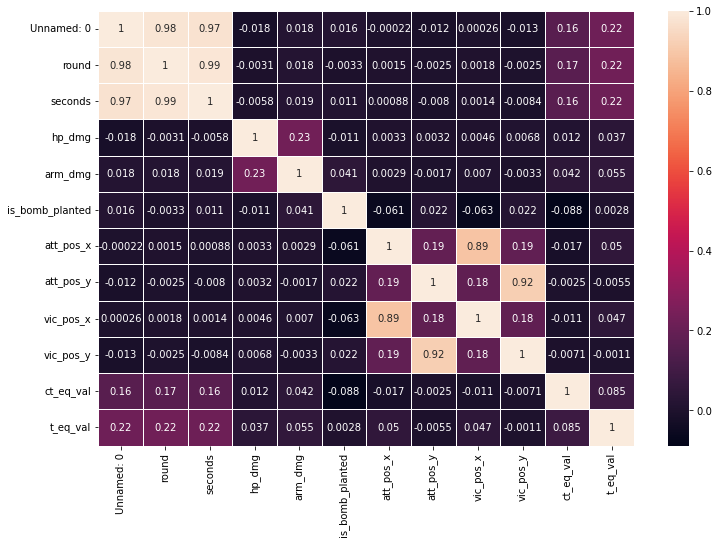

In [21]:
correlacio = mm_master_demos.corr()
plt.subplots(figsize = (12,8))
#plt.figure()
ax = sns.heatmap(correlacio, annot=True, linewidths=.5)
# falta codificar el winner team